
# Latent-space centers → decode → re-encode → nearest practicals (MNIST "4")

Pipeline:
1. Load **`latents.h5`** (`z`, `labels`) created by your training script.
2. Filter to label **4** latents: `z4`.
3. Compute latent **arithmetic mean**, **coordinate-wise median**, and **geometric median** (Weiszfeld) on `z4`.
4. **Decode** each latent center with your **decoder** (`decoder_weights.h5`) → reconstructed average images.
5. **Re-encode** those images with your **encoder** (`encoder_weights.h5`) → `z_mean_rec`, `z_median_rec`, `z_geomed_rec`.
6. Find **nearest practical image** (from your original latent set `z_all`) by:
   - **Euclidean** distance
   - **Cosine** similarity
7. **Interactive figure** to toggle metric and view the three practical images (mean / median / geomedian).

> Set `BASE_RESULTS_DIR` below to the folder containing `latents.h5`, `encoder_weights.h5`, and `decoder_weights.h5`.


In [1]:

# ───────────────────────────────────────────────
# Configuration — update this to your directory
# ───────────────────────────────────────────────
BASE_RESULTS_DIR = r"D:\Results\082725_mnist_ae_2"  # <-- change if needed

LATENTS_H5    = rf"{BASE_RESULTS_DIR}\latents.h5"
ENCODER_H5    = rf"{BASE_RESULTS_DIR}\encoder_weights.h5"
DECODER_H5    = rf"{BASE_RESULTS_DIR}\decoder_weights.h5"

print("Using:")
print("  LATENTS_H5:", LATENTS_H5)
print("  ENCODER_H5:", ENCODER_H5)
print("  DECODER_H5:", DECODER_H5)


Using:
  LATENTS_H5: D:\Results\082725_mnist_ae_2\latents.h5
  ENCODER_H5: D:\Results\082725_mnist_ae_2\encoder_weights.h5
  DECODER_H5: D:\Results\082725_mnist_ae_2\decoder_weights.h5


In [2]:

%matplotlib widget

import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import ipywidgets as W

try:
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import (
        Input, Conv2D, AveragePooling2D, Flatten, Dense, Reshape,
        Conv2DTranspose, ReLU
    )
except Exception as e:
    raise ImportError(
        "TensorFlow is required in this notebook. Install into the active kernel with:\n"
        "  %pip install tensorflow\n\n"
        f"Original error: {e}"
    )

def geometric_median(X, eps=1e-5, max_iter=512, verbose=False):
    """Weiszfeld's algorithm for geometric median in R^d.

    Args:
        X: (n_samples, d) float array
    Returns:
        (d,) float32 geometric median
    """
    X = np.asarray(X, dtype=np.float64)
    m = np.median(X, axis=0).astype(np.float64, copy=True)
    for it in range(max_iter):
        diffs = X - m
        dists = np.linalg.norm(diffs, axis=1)
        zero_mask = dists < eps
        if np.any(zero_mask):
            return X[zero_mask][0].astype(np.float32)
        inv_d = 1.0 / np.maximum(dists, eps)
        weights = inv_d / inv_d.sum()
        m_new = (weights[:, None] * X).sum(axis=0)
        move = np.linalg.norm(m_new - m)
        m = m_new
        if verbose and (it % 20 == 0):
            print(f"[iter {it}] move={move:.3e}")
        if move < eps:
            break
    return m.astype(np.float32)


In [3]:

# Load MNIST in the same order used when latents were generated (train then test)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0
x_train = np.expand_dims(x_train, -1)  # (60000,28,28,1)
x_test  = np.expand_dims(x_test,  -1)  # (10000,28,28,1)

images_all = np.concatenate([x_train, x_test], axis=0)   # (70000,28,28,1)
labels_all = np.concatenate([y_train, y_test], axis=0)   # (70000,)

# Load latents + labels
if not os.path.exists(LATENTS_H5):
    raise FileNotFoundError(f"latents.h5 not found at: {LATENTS_H5}")
with h5py.File(LATENTS_H5, "r") as hf:
    z_all = hf["z"][:]        # (N, d)
    y_lat = hf["labels"][:]   # (N,)

print("images_all:", images_all.shape, "labels_all:", labels_all.shape)
print("z_all:", z_all.shape, "y_lat:", y_lat.shape)

assert images_all.shape[0] == z_all.shape[0], "Mismatch: images vs latent rows"
assert labels_all.shape[0] == y_lat.shape[0], "Mismatch: labels vs latent rows"
latent_dim = z_all.shape[1]


images_all: (70000, 28, 28, 1) labels_all: (70000,)
z_all: (70000, 256) y_lat: (70000,)


In [4]:

# Encoder
inp = Input((28,28,1), name="encoder_input")
x = inp
for filters in [64, 128]:
    x = Conv2D(filters, 3, padding="same")(x)
    x = ReLU()(x)
    x = Conv2D(filters, 3, padding="same")(x)
    x = ReLU()(x)
    x = AveragePooling2D(pool_size=2)(x)
flat = Flatten()(x)
z_enc = Dense(latent_dim, name="z")(flat)
encoder = Model(inp, z_enc, name="encoder")

if not os.path.exists(ENCODER_H5):
    raise FileNotFoundError(f"encoder_weights.h5 missing at: {ENCODER_H5}")
encoder.load_weights(ENCODER_H5)
print("Loaded encoder weights.")

# Decoder
latent_in = Input((latent_dim,), name="z_sampling")
x = Dense(7 * 7 * 128)(latent_in)
x = Reshape((7, 7, 128))(x)
for filters in [128, 64]:
    x = Conv2DTranspose(filters, 3, strides=2, padding="same")(x)
    x = ReLU()(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = ReLU()(x)
decoded_img = tf.keras.layers.Conv2D(1, 3, padding="same", activation="sigmoid", name="decoder_output")(x)
decoder = Model(latent_in, decoded_img, name="decoder")

if not os.path.exists(DECODER_H5):
    raise FileNotFoundError(f"decoder_weights.h5 missing at: {DECODER_H5}")
decoder.load_weights(DECODER_H5)
print("Loaded decoder weights.")


Loaded encoder weights.
Loaded decoder weights.


In [5]:

mask4 = (y_lat == 4)
z4 = z_all[mask4].astype(np.float32)
print("z4 shape:", z4.shape)

z4_mean   = z4.mean(axis=0).astype(np.float32)
z4_median = np.median(z4, axis=0).astype(np.float32)
z4_geomed = geometric_median(z4, eps=1e-5, max_iter=512, verbose=False)

centers_latent = {
    "Arithmetic mean": z4_mean,
    "Coordinate median": z4_median,
    "Geometric median": z4_geomed,
}
{ k: v.shape for k, v in centers_latent.items() }


z4 shape: (6824, 256)


{'Arithmetic mean': (256,),
 'Coordinate median': (256,),
 'Geometric median': (256,)}

In [6]:

# Decode latent centers to images
recon_imgs = {}
for name, zc in centers_latent.items():
    pred = decoder.predict(zc[None, :], verbose=0)  # (1,28,28,1)
    recon_imgs[name] = pred[0]  # (28,28,1)

# Re-encode those reconstructions
reenc_latents = {}
for name, img in recon_imgs.items():
    z_rec = encoder.predict(img[None, ...], verbose=0)[0]  # (latent_dim,)
    reenc_latents[name] = z_rec.astype(np.float32)

{ k: v.shape for k, v in reenc_latents.items() }


{'Arithmetic mean': (256,),
 'Coordinate median': (256,),
 'Geometric median': (256,)}

In [7]:

eps = 1e-8
z_all_f = z_all.astype(np.float32, copy=False)
z_norms = np.linalg.norm(z_all_f, axis=1, keepdims=True)
z_unit  = z_all_f / np.maximum(z_norms, eps)

nearest = {
    "Euclidean":   {},
    "Cosine":      {},
    "Euclidean_d": {},
    "Cosine_s":    {},
}

for name, zc in reenc_latents.items():
    # Euclidean
    ed = np.linalg.norm(z_all_f - zc[None, :], axis=1)
    e_idx = int(np.argmin(ed))
    nearest["Euclidean"][name]   = e_idx
    nearest["Euclidean_d"][name] = float(ed[e_idx])

    # Cosine
    zc_unit = zc / max(np.linalg.norm(zc), eps)
    sim = (z_unit @ zc_unit)
    c_idx = int(np.argmax(sim))
    nearest["Cosine"][name]   = c_idx
    nearest["Cosine_s"][name] = float(sim[c_idx])

nearest


{'Euclidean': {'Arithmetic mean': 3639,
  'Coordinate median': 3639,
  'Geometric median': 3639},
 'Cosine': {'Arithmetic mean': 28089,
  'Coordinate median': 28089,
  'Geometric median': 28089},
 'Euclidean_d': {'Arithmetic mean': 2.64852237701416,
  'Coordinate median': 2.5239624977111816,
  'Geometric median': 2.533623695373535},
 'Cosine_s': {'Arithmetic mean': 0.8453248739242554,
  'Coordinate median': 0.85368812084198,
  'Geometric median': 0.8534987568855286}}

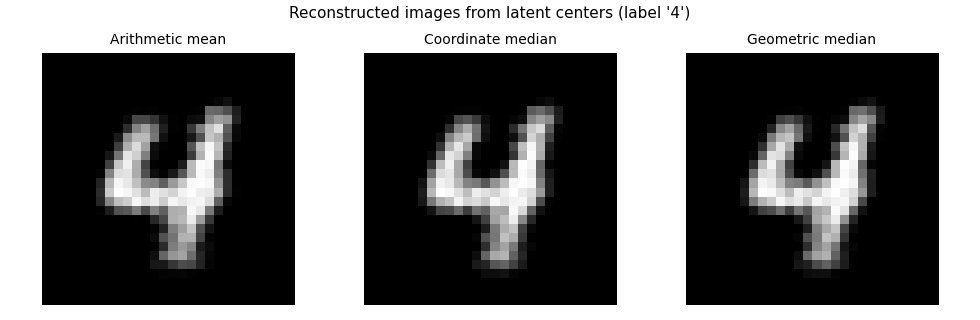

In [8]:
#| label: fig:mnist-ae-four-theory
#| caption: "MNIST '4' theoretical representative images: mean (left), median (middle), geometric median (right)."

def plot_reconstructed_averages():
    fig, axes = plt.subplots(1, 3, figsize=(9.8, 3.2))
    for ax, (nm, img) in zip(axes, recon_imgs.items()):
        ax.imshow(img[:, :, 0], cmap="gray")
        ax.set_title(nm, fontsize=10)
        ax.axis("off")
    fig.suptitle("Reconstructed images from latent centers (label '4')", fontsize=11)
    fig.tight_layout()
    plt.show()

plot_reconstructed_averages()


In [9]:
#| label: fig:mnist-ae-four-practical
#| caption: "MNIST '4' practical representative images: mean (left), median (middle), geometric median (right)."

metric_widget = W.ToggleButtons(
    options=[("Euclidean distance", "Euclidean"), ("Cosine similarity", "Cosine")],
    value="Euclidean",
    description="Metric:",
    disabled=False,
    layout=W.Layout(width="auto")
)
out = W.Output()

def show_practicals(metric):
    with out:
        out.clear_output(wait=True)
        names = ["Arithmetic mean", "Coordinate median", "Geometric median"]
        fig, axes = plt.subplots(1, 3, figsize=(10.5, 3.8))
        for ax, nm in zip(axes, names):
            idx = nearest[metric][nm]
            img = images_all[idx, :, :, 0]
            if metric == "Euclidean":
                extra = f"d={nearest['Euclidean_d'][nm]:.4f}  idx={idx}  label={labels_all[idx]}"
            else:
                extra = f"sim={nearest['Cosine_s'][nm]:.4f}  idx={idx}  label={labels_all[idx]}"
            ax.imshow(img, cmap="gray")
            ax.set_title(f"{nm}\n{metric}: {extra}", fontsize=9)
            ax.axis("off")
        fig.suptitle("Practical images nearest to re-encoded reconstructed centers", fontsize=11)
        fig.tight_layout()
        plt.show()

W.interactive_output(show_practicals, {"metric": metric_widget})
display(metric_widget, out)


ToggleButtons(description='Metric:', layout=Layout(width='auto'), options=(('Euclidean distance', 'Euclidean')…

Output()